## EMNIST Dataset Classification using Logistic Regression:

Write a logistic regression model to classify the letters from the [EMNIST](https://www.nist.gov/itl/products-and-services/emnist-dataset) letters dataset. Create an 80/20 train/test split of the data. You've been provided a template to carry this out. Fill in the suitable sections of the code.

- First train your model to perform binary classification between the letters b and d. Visualize performance on the training and test sets using a confusion matrix.
- Next, train your model to perform multiclass classification between b, d, p and q. Visualize performance on the training and test sets using a confusion matrix. 

In [ ]:
import torchvision
import jax.numpy as jnp
import jax
import matplotlib.pyplot as pl
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split

Downloading the Dataset:

In [ ]:
dataset = torchvision.datasets.EMNIST(root='./', split='letters', train=True, download=True)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [ ]:
X = jnp.array(dataset.data)
y = jnp.array(dataset.targets)
#print(dataset.classes)
#print(X[1, :, :])
#print(y.shape)
# Fill in the code below to get letter b, d, p and q from the dataset
i_b = jnp.where(y == 2)[0]
i_d = jnp.where(y == 4)[0]
i_p = jnp.where(y == 16)[0]
i_q = jnp.where(y == 17)[0]

X_b = X[i_b]
X_d = X[i_d]
X_p = X[i_p]
X_q = X[i_q]

Y_b = y[i_b]
Y_d = y[i_d]
Y_p = y[i_p]
Y_q = y[i_q]


# Combine them below to create datasets for usage in following parts
# create X_bd, Y_bd for binary classification
X_bd = jnp.concatenate((X_b, X_d), axis = 0)
Y_bd = jnp.concatenate((Y_b, Y_d), axis = 0)
# create X_bdpq, Y_bdpq for multiclass classification
X_bdpq = jnp.concatenate((X_b, X_d, X_p, X_q), axis = 0)
Y_bdpq = jnp.concatenate((Y_b, Y_d, Y_p, Y_q), axis = 0)

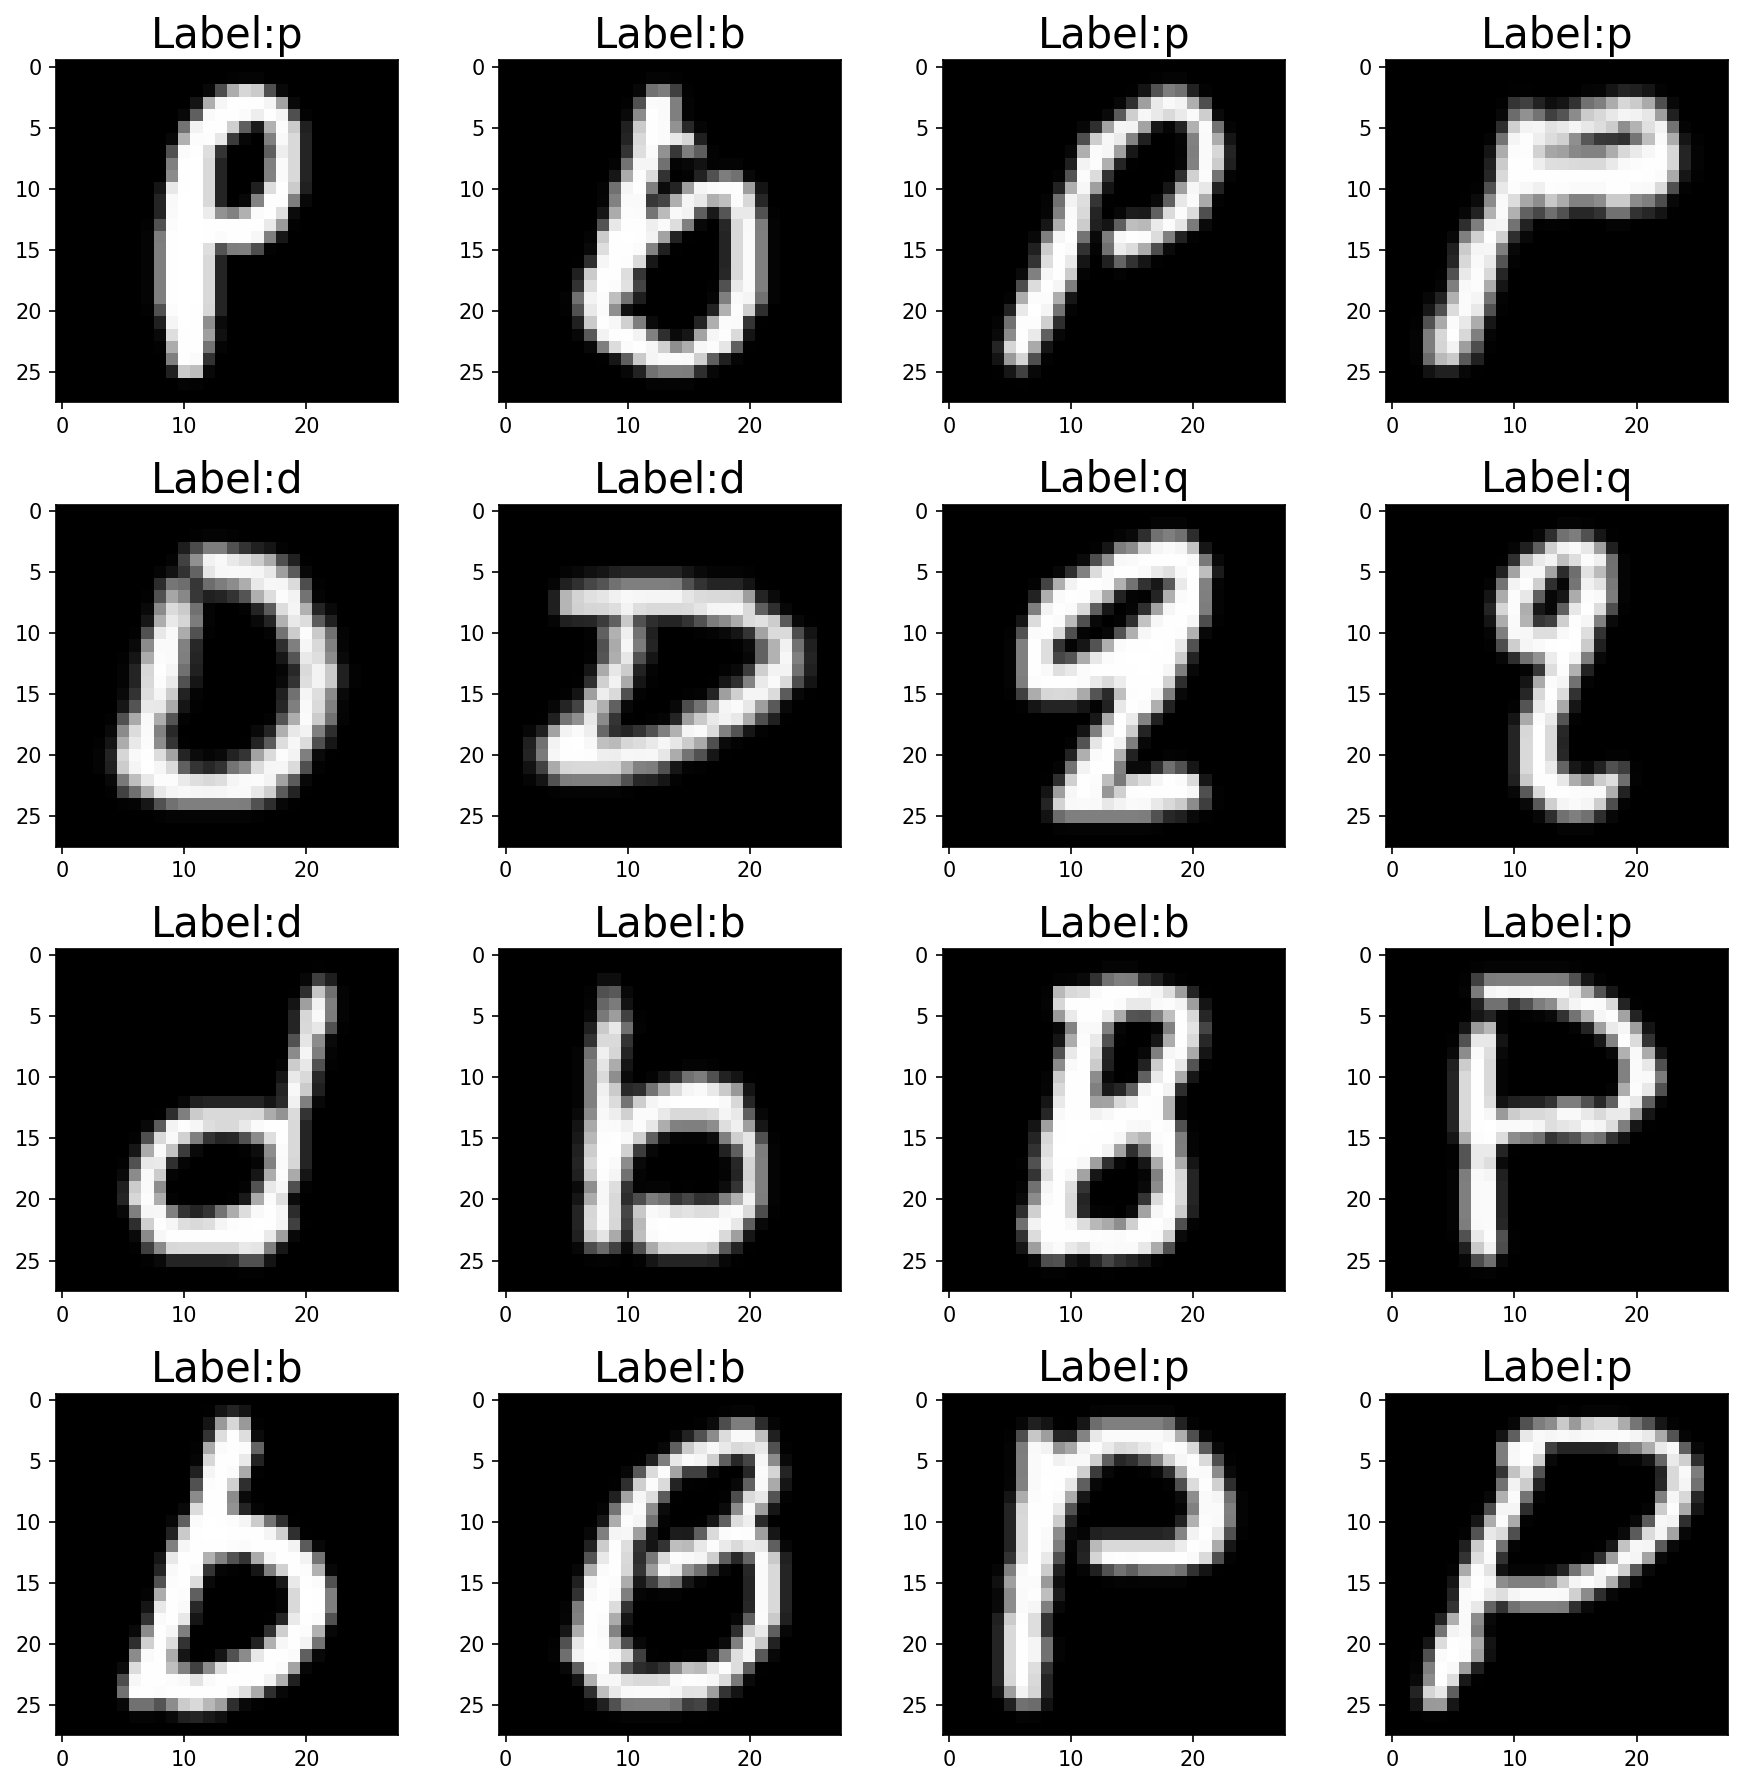

In [ ]:
# Check that the mapping was performed correctly by utilizing a few examples:
# Visualizing that your mapping is performed correctly
rnd_idx = jax.random.randint(jax.random.PRNGKey(56), (16,), 0, X_bdpq.shape[0])
# assuming that the labels are mapped as follows: b -> 2, d -> 4, p -> 16, q -> 17
str_labels = {'2' : 'b', '4' : 'd', '16':'p', '17':'q'}
pl.figure(dpi = 150, figsize=(12,12))
for index, (image, label) in enumerate(zip(X_bdpq[rnd_idx], Y_bdpq[rnd_idx])):
    pl.subplot(4, 4, index + 1)
    pl.imshow(jnp.reshape(image, (28, 28)).T, cmap=pl.cm.gray)
    pl.title('Label:' + str_labels[str(label)], fontsize = 20)
pl.tight_layout()

In [ ]:
# Fill in the code to perform an 80-20 train-test split on X_bd and y_bd to yield X_train, y_train, X_test, y_test:
X_train, X_test, Y_train, Y_test = train_test_split(X_bd, Y_bd, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

Y_train = Y_train.at[Y_train == 2].set(0)
Y_test = Y_test.at[Y_test == 2].set(0)
Y_train = Y_train.at[Y_train == 4].set(1)
Y_test = Y_test.at[Y_test == 4].set(1)

Y_train = jnp.expand_dims(Y_train, axis=1)
Y_test = jnp.expand_dims(Y_test, axis=1)

In [ ]:
def forward(params, X):
    return jax.nn.sigmoid(X @ params)

@jax.jit
def loss_fn(params, X, y):
  al = forward(params, X)
  loss = -jnp.mean((y * jnp.log(al+1e-8)) + (1-y) * jnp.log(1-al+1e-8))
  return loss

# Computing Gradients:
grad_loss = jax.jit(jax.grad(loss_fn))

In [ ]:
# Initializing weights as zeros:
params = jnp.zeros([784, 1])
#print(grad_loss(params, X_train, Y_train).shape)
# Gradient descent
# Learning Rate

alpha = 5e-6
n_its = 5000

loss_history = [loss_fn(params, X_train, Y_train)]

for i in range(n_its):
  #print("params", params[5])
  #print("loss", loss_fn(params, X_train, Y_train))
  g      = grad_loss(params, X_train, Y_train)
  
  
  #print("grad", g[5])
  #print("alpha_g", alpha*g[5])
  params = jax.tree_map(lambda x, g: x - alpha * g, params, g)
  #print("params", params[5])
  #print("\n")
  # Track progress:
  loss_history = loss_history + [loss_fn(params, X_train, Y_train)]
  # if i % 5 == 0:
  #   print('iter', i, 'loss', loss_fn(params, X_train, Y_train))

Text(0.5, 0, 'Number of Iterations')

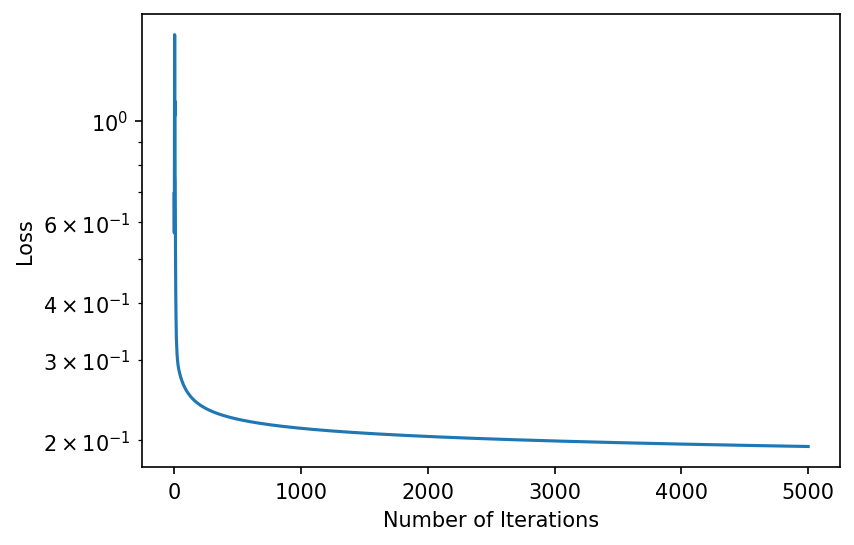

In [ ]:
# Plotting the loss history
pl.figure(dpi = 150)
pl.semilogy(loss_history)
pl.ylabel('Loss')
pl.xlabel('Number of Iterations')

In [ ]:
# Computing Accuracy Score and Resulting Confusion Matrix for test set:
accuracy_score = (jnp.round(forward(params, X_test)).ravel() == Y_test).mean()
cm             = metrics.confusion_matrix(Y_test, jnp.round(forward(params, X_test)))
cm_normalized  = cm.astype('float') / cm.sum(axis=1)[:, jnp.newaxis]

print('Accuracy Score on Test Set:', accuracy_score)

Accuracy Score on Test Set: 0.5001649


Text(0.5, 1.0, 'Confusion Matrix')

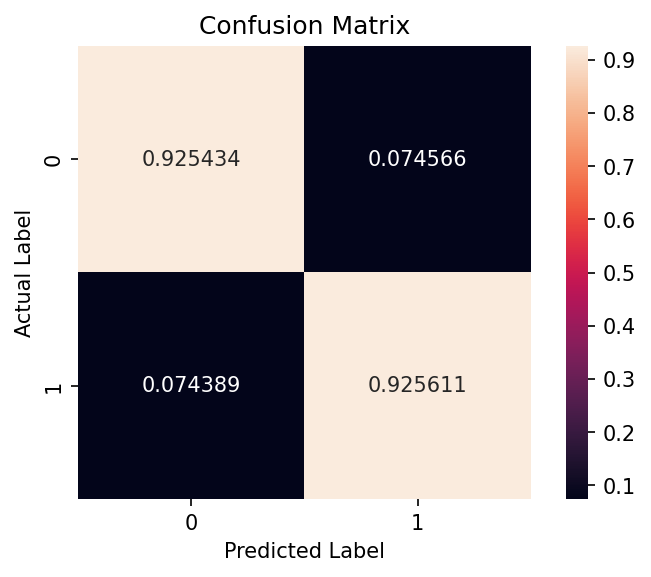

In [ ]:
pl.figure(dpi = 150)
sns.heatmap(cm_normalized, fmt = '4f', annot = True, square = True);
pl.ylabel('Actual Label');
pl.xlabel('Predicted Label');
pl.title('Confusion Matrix')

In [ ]:
# Fill in the code to perform an 80-20 train-test split on X_bdpq and y_bdpq to yield X_train, y_train, X_test, y_test:
X_train, X_test, Y_train, Y_test = train_test_split(X_bdpq, Y_bdpq, test_size=0.2, random_state=40)

X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

Y_train = Y_train.at[Y_train == 2].set(0)
Y_test = Y_test.at[Y_test == 2].set(0)
Y_train = Y_train.at[Y_train == 4].set(1)
Y_test = Y_test.at[Y_test == 4].set(1)
Y_train = Y_train.at[Y_train == 16].set(2)
Y_test = Y_test.at[Y_test == 16].set(2)
Y_train = Y_train.at[Y_train == 17].set(3)
Y_test = Y_test.at[Y_test == 17].set(3)

#One hot encoding:
Y_train = jax.nn.one_hot(Y_train, 4)
Y_test = jax.nn.one_hot(Y_test, 4)


In [ ]:
def forward(params, X):
    return jax.nn.softmax(X @ params)
# params = jnp.zeros([784, 4])
# sm = forward(params, X_train)

@jax.jit
def loss_fn(params, X, y):
  sft_max = forward(params, X)
  loss  = -jnp.mean(y * jnp.log(sft_max))
  return loss

# Computing Gradients:
grad_loss = jax.jit(jax.grad(loss_fn))

In [ ]:
# Initializing weights as zeros:
params = jnp.zeros([784, 4])

# Gradient descent
# Learning Rate
alpha = 1e-6
n_its = 50000

loss_history = [loss_fn(params, X_train, Y_train)]
for i in range(n_its):
    g      = grad_loss(params, X_train, Y_train)
    params = jax.tree_map(lambda x, g: x - alpha * g, params, g)

    # Track progress:
    loss_history = loss_history + [loss_fn(params, X_train, Y_train)]

Text(0.5, 0, 'Number of Iterations')

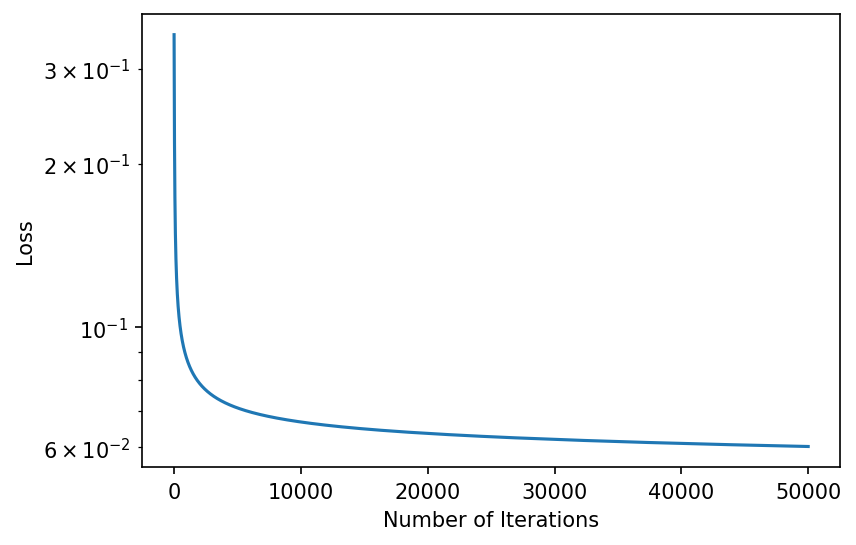

In [ ]:
pl.figure(dpi = 150)
pl.semilogy(loss_history)
pl.ylabel('Loss')
pl.xlabel('Number of Iterations')

In [ ]:
# Computing Accuracy Score and Resulting Confusion Matrix for test set:
accuracy_score = (jnp.argmax(forward(params, X_test), axis = 1) == 
                  jnp.argmax(Y_test, axis = 1)).mean()
cm             = metrics.confusion_matrix(jnp.argmax(Y_test, axis = 1), 
                                          jnp.argmax(forward(params, X_test), axis = 1))
cm_normalized  = cm.astype('float') / cm.sum(axis=1)[:, jnp.newaxis]
print('Accuracy Score on Test Set:', accuracy_score)

Accuracy Score on Test Set: 0.9065105


Text(0.5, 1.0, 'Confusion Matrix')

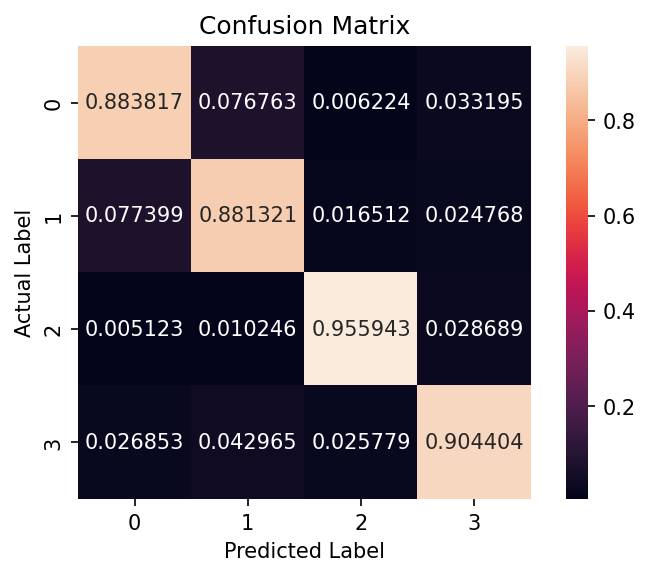

In [ ]:
pl.figure(dpi = 150)
sns.heatmap(cm_normalized, fmt = '4f', annot = True, square = True);
pl.ylabel('Actual Label');
pl.xlabel('Predicted Label');
pl.title('Confusion Matrix')